In [1]:
import pandas as pd
import pickle
import numpy  as np
from time import time
#train_test_split
from sklearn.model_selection import train_test_split
#Feature scaling
from sklearn import preprocessing
from collections import Counter
import math
from sklearn.metrics import accuracy_score

In [2]:
def load_obj(name):
    with open('../DistributionDictionary/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

distributions = {}
distributions['Benign'] = load_obj("Benign_Distribution_set")
distributions['DoS'] = load_obj("DoS_Distribution_set")
distributions['PortScan'] = load_obj("PortScan_Distribution_set")
distributions['DDoS'] = load_obj("DDoS_Distribution_set")
distributions['SSH'] = load_obj("SSH_Distribution_set")
distributions['FTP'] = load_obj("FTP_Distribution_set")
distributions['Web'] = load_obj("Web_Distribution_set")
distributions['Bot'] = load_obj("Bot_Distribution_set")

attack_types = 7  #总已知攻击种类

#定义difference weight,取值0~1
def calculate_dw(distribution_1, distribution_2, feature_index):
    count1 = calculate_count(distribution_1, feature_index)
    count2 = calculate_count(distribution_2, feature_index)
    h = 20
    dw = 0
    for i in range(h):
        start = i*5
        end = start + 5
        T1 = distribution_1[str(feature_index)][str(start) + '-' + str(end)]/count1
        T2 = distribution_2[str(feature_index)][str(start) + '-' + str(end)]/count2
        dw += abs(T1 - T2)
    return dw/2
#用于计算分布字典里的实例数
def calculate_count(distribution, feature_index):
    h = 20
    count = 0
    for i in range(h):
        start = i*5
        end = start + 5
        count += distribution[str(feature_index)][str(start) + '-' + str(end)]
    return count
#定义hdw，hybird difference weight
def calculate_hdw(feature_index):
    base = 0
    for key in distributions:
        if(key == "Benign"):
            continue
        dw = calculate_dw(distributions['Benign'], distributions[key], feature_index)
        if(dw > base):
            base = dw
    return base


#计算例子在某种标签上的得分，需要提供对应标签的分布统计字典和字典的统计量
def get_score(example, distributeObj):    
    score = 0
    count = calculate_count(distributeObj, 0)  #取哪个特征都一样
    minBase = 1
    baseArr = []
    for i in range(feature_numbers):

        start = int(example[i]/0.05//1)*5   #取200个分组里的分组起始位置
        if(start == 100):     #特殊处理当该属性为1.0时溢出的情况
            start = 95      
        end = start + 5
        dataRange = '{0}-{1}'.format(start, end )
        base = distributeObj[str(i)][dataRange]/count
        if(base != 0 and base < minBase):
            minBase = base
        baseArr.append(base)
        
    for i in range(feature_numbers):
        if(baseArr[i] != 0):
            score += math.log(baseArr[i]) * calculate_hdw(i)  / feature_numbers
        else:
            score += math.log(minBase) * calculate_hdw(i)  / feature_numbers
            
    return score
def get_max(array):
    base = 0
    for value in array:
        if(base < value):
            base = value
    return base
def get_min(array):
    base = array[0]
    for value in array:
        if(base > value):
            base = value
    return base
def get_average(array):
    return float(sum(array))/len(array)
def get_medium(array):
    array.sort()
    mid = int(len(array) / 2)
    if len(array) % 2 == 0:
        median = (array[mid - 1] + array[mid]) / 2.0
    else:
        median = array[mid]
    return median
def get_analysis(label_num):
    count = 0.0
    judge_attack_count = 0.0
    Indexs = []
    for index, item in enumerate(test_y3):  
        if(item == label_num):
            Indexs.append(index)
            count+=1
    Scores = []
    for index, item in enumerate(Indexs):
        t = get_score(test_x3[item], distributions['Benign'])
        if(t == "attack"):
            judge_attack_count+=1
            t = -4.0
        Scores.append(t)

    print(get_max(Scores))
    print(get_min(Scores))
    print(get_medium(Scores))
    print(get_average(Scores))  
    print(judge_attack_count / count) 
    return Scores

In [3]:
def read_csv(dataroot):
    df=pd.read_csv(dataroot,header=0,low_memory=False)   
    pd.set_option('mode.use_inf_as_na', True) # convert inf to nan
    df['Flow Bytes/s']=df['Flow Bytes/s'].astype('float64')
    df[' Flow Packets/s']=df[' Flow Packets/s'].astype('float64')
    df['Flow Bytes/s'].fillna(df['Flow Bytes/s'].mean(),inplace=True)
    df[' Flow Packets/s'].fillna(df[' Flow Packets/s'].mean(),inplace=True)
    return df

def split_valid_from_train(train_dataset, valid_size):
    # Method 1
    train_dataset, valid_dataset, _, _ = train_test_split(train_dataset, train_dataset[' Label'], test_size=valid_size, random_state=None)
    # pandas中先重置index再打乱train. 否则只会调整各个行的顺序，而不会改变pandas的index
    # 重置
    train_dataset = train_dataset.reset_index(drop=True)
    # 打乱
    indexMask = np.arange(len(train_dataset))
    for i in range(10):
        np.random.shuffle(indexMask)
    train_dataset = train_dataset.iloc[indexMask]

    return train_dataset, valid_dataset

def shuffle(dataset):  
    # 打乱
    indexMask = np.arange(len(dataset))
    for i in range(10):
        np.random.shuffle(indexMask)
    dataset = dataset.iloc[indexMask]
    dataset = dataset.reset_index(drop=True)

    return dataset 

#独热编码。选取distination port统计大于等于10以上的port作为新增维度
def create_columns_for_destination_port(train_dataset):
    countDictionary = Counter(train_dataset[' Destination Port'])
    columns = []
    columns.append('DestinationPort_Others')
    for key in countDictionary:
        if(countDictionary[key] >= 10):
            columns.append('DestinationPort_' + str(key))
    return columns

def one_hot_process_for_destination_port(dataset, columns):
    #重置索引
    dataset = dataset.reset_index(drop=True)
    #创建空表
    DestinationPort_revert = pd.DataFrame(data=np.zeros(shape=(dataset.shape[0],len(columns))), columns = columns)
    #填充空表
    for i,value in enumerate(dataset[' Destination Port'].values):
        name = "DestinationPort_" + str(value)
        if name in columns:
            DestinationPort_revert.loc[i, name] = 1
        else:
            DestinationPort_revert.loc[i, "DestinationPort_Others"] = 1
    #与原表连接
    dataset = pd.concat([dataset, DestinationPort_revert], axis=1)
    #删除原表的destination port列
    dataset = dataset.drop([' Destination Port'], axis=1)
    return dataset  



def labels_separate(dataset):
    y_ = dataset[' Label']
    temp = dataset
    temp.drop([' Label'], axis=1, inplace=True)
    x_ = temp.values
    return x_, y_

def labels_map(label):
    if(type(label) == int):      #已是数字，无需处理
        return label
    if label == 'BENIGN':
        return 0
    if label == 'DoS':
        return 1
    if label == 'PortScan':
        return 2
    if label == 'DDoS':
        return 3
    if label == 'SSH-Patator':
        return 4
    if label == 'FTP-Patator':
        return 5
    if label == 'Web Attack':
        return 6
    if label == 'Bot':
        return 7
    if label == 'Infiltration':
        return 8
    return -1   #-1表示出错
def filter_labels(dataset):
    dataset[' Label'] = dataset[' Label'].apply(labels_map)
    return dataset
#特征选取
def feature_selection(dataset):
    return dataset[[
        ' Destination Port', 'Bwd Packet Length Max',' Bwd Packet Length Min', ' Bwd Packet Length Std',
        ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Min', ' Fwd IAT Min', ' Bwd Packets/s', ' Min Packet Length',
        ' Max Packet Length', ' Init_Win_bytes_backward', ' act_data_pkt_fwd', ' Label'
    ]]
def feature_selection2(dataset):
    return dataset[[' Destination Port', ' Flow Duration', ' Total Fwd Packets', 'Total Length of Fwd Packets', 
                    ' Total Length of Bwd Packets', ' Fwd Packet Length Std', 'Bwd Packet Length Max', 
                    ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow IAT Mean', 
                    ' Flow IAT Max', ' Flow IAT Min', ' Fwd IAT Mean', ' Fwd IAT Max', ' Fwd IAT Min', 
                    ' Bwd IAT Min', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', 
                    ' Bwd Packets/s', ' Max Packet Length', ' Packet Length Variance', ' ACK Flag Count', 
                    ' URG Flag Count', ' Average Packet Size', ' Avg Bwd Segment Size', ' Fwd Header Length.1', 
                    ' Subflow Fwd Bytes', 'Init_Win_bytes_forward', ' Init_Win_bytes_backward', 
                    ' act_data_pkt_fwd', ' Label'
                   ]]


labelList = ["BENIGN", "DoS", "PortScan", "DDoS", "SSH-Patator", "FTP-Patator", "Web Attack", "Bot"]

In [4]:
#DDoS
df_1 = read_csv("../MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
df_1 = df_1.drop(df_1[df_1[' Label'] == 'BENIGN'].index)
df_1 = df_1.sample(n=5000,random_state=1, replace=False)
df_1_train, df_1_test = split_valid_from_train(df_1, 0.2)
#PortScan
df_2 = read_csv("../MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
df_2 = df_2.drop(df_2[df_2[' Label'] == 'BENIGN'].index)
df_2 = df_2.sample(n=5000,random_state=1, replace=False)
df_2_train, df_2_test = split_valid_from_train(df_2, 0.2)
#Bot
df_3 = read_csv("../MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv")
df_3 = df_3.drop(df_3[df_3[' Label'] == 'BENIGN'].index)
df_3 = df_3.sample(n=5000,random_state=1, replace=True)
df_3_train, df_3_test = split_valid_from_train(df_3, 0.2)
#Benign
df_4 = read_csv("../MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv")
df_4 = df_4.sample(n=50000,random_state=1, replace=False)
df_4_train, df_4_test = split_valid_from_train(df_4, 0.2)
#Web attack
df_6 = read_csv("../MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
df_6 = df_6.drop(df_6[df_6[' Label'] == 'BENIGN'].index)
df_6 = df_6.sample(n=5000,random_state=1, replace=True)
df_6[' Label'] = df_6[' Label'].apply(lambda x: 'Web Attack')
df_6_train, df_6_test = split_valid_from_train(df_6, 0.2)
#FTP-Patator and SSH-Patator
df_7 = read_csv("../MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv")
df_7 = df_7.drop(df_7[df_7[' Label'] == 'BENIGN'].index)
df_7_1 = df_7.drop(df_7[df_7[' Label'] == 'FTP-Patator'].index)
df_7_2 = df_7.drop(df_7[df_7[' Label'] == 'SSH-Patator'].index)
df_7_1 = df_7_1.sample(n=5000,random_state=1, replace=False)
df_7_2 = df_7_2.sample(n=5000,random_state=1, replace=False)
df_7_1_train, df_7_1_test = split_valid_from_train(df_7_1, 0.2)
df_7_2_train, df_7_2_test = split_valid_from_train(df_7_2, 0.2)
#DoS
df_8 = read_csv("../MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv")
df_8 = df_8.drop(df_8[df_8[' Label'] == 'BENIGN'].index)
df_8 = df_8.sample(n=5000,random_state=1, replace=False)
df_8[' Label'] = df_8[' Label'].apply(lambda x: 'DoS')
df_8_train, df_8_test = split_valid_from_train(df_8, 0.2)

#整合
df_train = df_1_train.append([df_2_train, df_3_train, df_4_train, df_6_train, df_7_1_train,df_7_2_train,df_8_train])
df_test = df_1_test.append([df_2_test, df_3_test, df_4_test, df_6_test, df_7_1_test,df_7_2_test,df_8_test])

In [5]:
print(df_train.shape)
print(df_train.loc[:,' Label'].value_counts())
print(df_test.shape)
print(df_test.loc[:,' Label'].value_counts())

(68000, 79)
BENIGN         40000
SSH-Patator     4000
PortScan        4000
FTP-Patator     4000
DDoS            4000
Web Attack      4000
Bot             4000
DoS             4000
Name:  Label, dtype: int64
(17000, 79)
BENIGN         10000
Web Attack      1000
Bot             1000
PortScan        1000
DoS             1000
FTP-Patator     1000
SSH-Patator     1000
DDoS            1000
Name:  Label, dtype: int64


In [6]:
import pickle
#数理统计方法，按5%区间进行数理统计
def statistics(dataset, feature_index):
    intervals = {'{0}-{1}'.format(5 * x, 5 * (x+1) ): 0 for x in range(20)}
    for _ in dataset[:,feature_index]:
        for interval in intervals:
            start, end = tuple(interval.split('-'))
            if int(start) <= _*100 <= int(end):
                intervals[interval] += 1
    return intervals

def save_obj(obj, name ):
    with open('../DistributionDictionary/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        

In [7]:
#整合后再乱序一下
df_train = shuffle(df_train)
#标签的字符转化成数字
df_train = filter_labels(df_train)
df_test = filter_labels(df_test)
#分离标签
df_train_X, df_train_y = labels_separate(df_train)
df_test_X, df_test_y = labels_separate(df_test)
#Normalization
scaler = preprocessing.MinMaxScaler()
df_train_X = scaler.fit_transform(df_train_X)
df_test_X = scaler.fit_transform(df_test_X)

In [8]:
print(df_train_X.shape)
print(df_train_y.shape)
print(df_test_X.shape)
print(df_test_y.shape)
print(df_train_X[0])
print(df_train_y)

(68000, 78)
(68000,)
(17000, 78)
(17000,)
[5.64867092e-01 4.50002700e-07 0.00000000e+00 2.32514881e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.23456730e-02
 4.94721854e-07 0.00000000e+00 4.50126819e-07 5.03883365e-07
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.92150477e-01 9.89850433e-01
 6.17283951e-03 1.38888889e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 2.00000000e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.92150477e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+

In [9]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from tensorflow.keras.layers import BatchNormalization
#超参数设置
learning_rate = 0.001
epochs = 20
batch_size = 64
activation = tf.nn.relu         #非输出层下的激活函数

In [33]:
#用于记录训练中每个batch的loss
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_losses_per_batch = []
        self.train_losses_per_epoch = []
        self.valid_losses_per_epoch = []
        
    def on_batch_end(self, batch, logs={}):
        self.train_losses_per_batch.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs={}):
        self.train_losses_per_epoch.append(logs.get('loss'))
        self.valid_losses_per_epoch.append(logs.get('val_loss')*4)   #验证集由于只有1/4的训练集大小所以损失要乘以4
#用于记录训练中每个epoch的召回率，精确度以及f1 score
class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        return

    def on_epoch_end(self, epoch, logs={}):
        predictions = self.model.predict(df_test_X)
        val_predict = np.argmax(predictions, axis=1)     #把独热编码转化成数字
        val_targ = df_test_y
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')
        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        return       
#回调：模型跑完epoch后选取最好的epoch模型保存，选取标准为验证集损失最小的那一个
checkpoint = keras.callbacks.ModelCheckpoint(      
    "./Test10_model.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    period=1
)
def simple_model():
    model = keras.Sequential([
        keras.layers.Dense(df_train_X.shape[1], activation=activation, input_shape=(df_train_X.shape[1],)),
        BatchNormalization(),
        keras.layers.Dense(64, activation=activation),
        BatchNormalization(),
        keras.layers.Dense(64, activation=activation),
        BatchNormalization(),
        keras.layers.Dense(8,activation=tf.nn.softmax)
    ])
    model.compile(optimizer =tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=['accuracy']
    )
    model.summary()
    history = LossHistory()
    metrics = Metrics()
    model.fit(
        df_train_X,df_train_y,
        validation_data=[df_test_X, df_test_y],
        batch_size=batch_size,epochs=epochs,
        callbacks=[history, metrics, checkpoint]
    )   
    return model,history,metrics
model,history,metrics = simple_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 78)                6162      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 78)                312       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                5056      
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 64)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 64)                256       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
Total para

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Epoch 00001: val_loss improved from inf to 2.69149, saving model to ./Test10_model.h5
68000/68000 [==============================] - 7s 110us/sample - loss: 0.2845 - acc: 0.9114 - val_loss: 2.6915 - val_acc: 0.6077
Epoch 2/20
67968/68000 [============================>.] - ETA: 0s - loss: 0.1548 - acc: 0.9452
Epoch 00002: val_loss did not improve from 2.69149
68000/68000 [==============================] - 6s 86us/sample - loss: 0.1549 - acc: 0.9452 - val_loss: 2.8795 - val_acc: 0.6772
Epoch 3/20
67584/68000 [============================>.] - ETA: 0s - loss: 0.1247 - acc: 0.9555
Epoch 00003: val_loss did not improve from 2.69149
68000/68000 [==============================] - 6s 93us/sample - loss: 0.1245 - acc: 0.9556 - val_loss: 3.1251 - val_acc: 0.6595
Epoch 4/20
67328/68000 [============================>.] - ETA: 0s - loss: 0.1068 - acc: 0.9611
Epoch 00004: val_loss did not improve from 2.69149
68000/68000 [==============================] - 6s 89us/sample - loss: 0.1071 - acc: 0.9611

In [34]:
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.rcParams['font.sans-serif'] = ['SimHei']

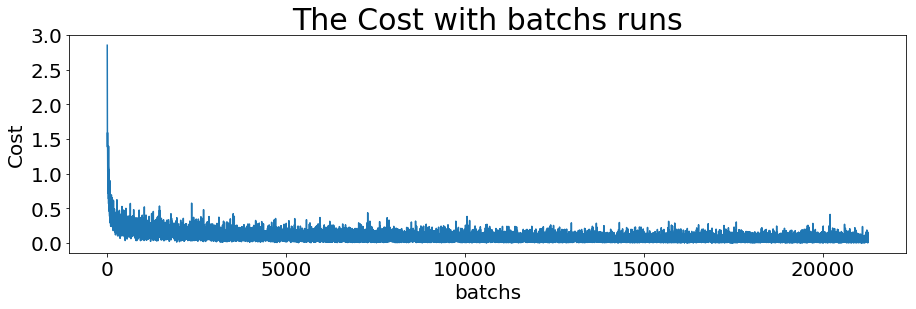

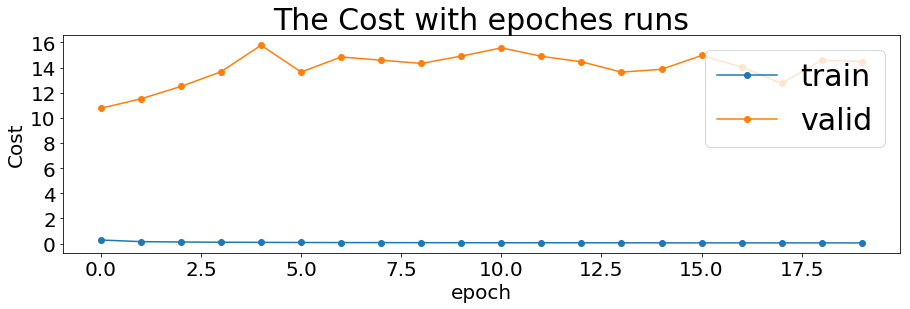

In [35]:
#绘制训练集在batch下的损失变化
plt.title('The Cost with batchs runs',fontsize=30)
plt.xlabel('batchs',fontsize=20)
plt.ylabel('Cost',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(history.train_losses_per_batch)
plt.gcf().set_size_inches(15,4)
plt.show()
#绘制训练集与验证集在epoch下的损失比较
plt.title('The Cost with epoches runs',fontsize=30)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('Cost',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(history.train_losses_per_epoch, '-o', label='train')
plt.plot(history.valid_losses_per_epoch, '-o', label='valid')
plt.legend(fontsize=30,loc='upper right')
plt.gcf().set_size_inches(15,4)
plt.show()

In [36]:
#选取验证集准确率最高的模型
model = keras.models.load_model('./Test10_model.h5') 
model.compile(optimizer =tf.train.AdamOptimizer(learning_rate=learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
#测试集的正确率
def use_evaluate_test():
    test_loss,test_acc = model.evaluate(df_test_X,df_test_y)
    print('Test accuracy:', test_acc)
    return 
use_evaluate_test()

17000/17000 [==============================] - 1s 81us/sample - loss: 2.6915 - acc: 0.6077
Test accuracy: 0.6077059


In [37]:
predictions = model.predict(df_test_X)
print(classification_report(df_test_y, np.argmax(predictions, axis=1) , target_names=labelList))

              precision    recall  f1-score   support

      BENIGN       0.68      0.85      0.76     10000
         DoS       0.76      0.56      0.64      1000
    PortScan       0.30      0.67      0.41      1000
        DDoS       1.00      0.00      0.00      1000
 SSH-Patator       0.00      0.00      0.00      1000
 FTP-Patator       0.70      0.36      0.47      1000
  Web Attack       0.00      0.00      0.00      1000
         Bot       0.35      0.23      0.28      1000

   micro avg       0.61      0.61      0.61     17000
   macro avg       0.47      0.33      0.32     17000
weighted avg       0.58      0.61      0.55     17000



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=3)
dt_clf = clf.fit(df_train_X, df_train_y)
predictions = dt_clf.predict(df_test_X)
print(predictions)
print(accuracy_score(df_test_y, predictions))

[3 3 3 ... 1 0 1]
0.9207058823529412


In [20]:
print(classification_report(df_test_y, predictions , target_names=labelList))

              precision    recall  f1-score   support

      BENIGN       0.96      0.97      0.96     10000
         DoS       0.99      0.68      0.81      1000
    PortScan       0.61      0.99      0.75      1000
        DDoS       0.84      1.00      0.91      1000
 SSH-Patator       1.00      1.00      1.00      1000
 FTP-Patator       0.98      1.00      0.99      1000
  Web Attack       0.98      0.91      0.95      1000
         Bot       0.85      0.38      0.53      1000

   micro avg       0.92      0.92      0.92     17000
   macro avg       0.90      0.87      0.86     17000
weighted avg       0.93      0.92      0.92     17000



In [21]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(df_train_X, df_train_y) 
# predictions = dt_clf.predict(df_test_X)
# print(predictions)
# print(accuracy_score(df_test_y, predictions))


/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[3 3 3 ... 1 0 1]
0.9207058823529412


In [29]:
predictions = clf.predict(df_test_X)
print(predictions)
print(accuracy_score(df_test_y, predictions))
print(classification_report(df_test_y, predictions , target_names=labelList))

[3 0 0 ... 1 0 1]
0.8374117647058823
              precision    recall  f1-score   support

      BENIGN       0.85      0.94      0.89     10000
         DoS       0.86      0.65      0.74      1000
    PortScan       0.78      0.99      0.87      1000
        DDoS       0.98      0.56      0.71      1000
 SSH-Patator       0.52      0.47      0.49      1000
 FTP-Patator       0.84      1.00      0.91      1000
  Web Attack       0.91      0.83      0.87      1000
         Bot       0.83      0.35      0.49      1000

   micro avg       0.84      0.84      0.84     17000
   macro avg       0.82      0.72      0.75     17000
weighted avg       0.84      0.84      0.83     17000



              precision    recall  f1-score   support

      BENIGN       0.96      0.97      0.96     10000
         DoS       0.99      0.68      0.81      1000
    PortScan       0.61      0.99      0.75      1000
        DDoS       0.84      1.00      0.91      1000
 SSH-Patator       1.00      1.00      1.00      1000
 FTP-Patator       0.98      1.00      0.99      1000
  Web Attack       0.98      0.91      0.95      1000
         Bot       0.85      0.38      0.53      1000

   micro avg       0.92      0.92      0.92     17000
   macro avg       0.90      0.87      0.86     17000
weighted avg       0.93      0.92      0.92     17000



In [24]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(df_train_X, df_train_y)
#测试集的正确率
print(rfc.score(df_test_X, df_test_y))
#测试集的各个参数
y_pred = rfc.predict(df_test_X)
print(classification_report(df_test_y, y_pred, target_names=labelList))

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9147647058823529
              precision    recall  f1-score   support

      BENIGN       0.87      1.00      0.93     10000
         DoS       0.99      0.93      0.96      1000
    PortScan       1.00      1.00      1.00      1000
        DDoS       0.99      0.65      0.78      1000
 SSH-Patator       1.00      0.99      1.00      1000
 FTP-Patator       1.00      0.77      0.87      1000
  Web Attack       1.00      0.92      0.96      1000
         Bot       1.00      0.31      0.47      1000

   micro avg       0.91      0.91      0.91     17000
   macro avg       0.98      0.82      0.87     17000
weighted avg       0.93      0.91      0.90     17000



In [26]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(df_train_X, df_train_y)
#测试集的正确率
print(xgb.score(df_test_X, df_test_y))
#测试集的各个参数
y_pred = xgb.predict(df_test_X)
print(classification_report(df_test_y, y_pred, target_names=labelList))

0.9146470588235294
              precision    recall  f1-score   support

      BENIGN       0.89      0.98      0.93     10000
         DoS       0.98      0.98      0.98      1000
    PortScan       1.00      0.49      0.66      1000
        DDoS       0.81      1.00      0.90      1000
 SSH-Patator       1.00      1.00      1.00      1000
 FTP-Patator       1.00      0.51      0.67      1000
  Web Attack       1.00      0.85      0.92      1000
         Bot       0.99      0.97      0.98      1000

   micro avg       0.91      0.91      0.91     17000
   macro avg       0.96      0.85      0.88     17000
weighted avg       0.92      0.91      0.91     17000



In [32]:
import sys

print(clf.__sizeof__())
print(rfc.__sizeof__())
print(xgb.__sizeof__())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
32
